# LTSF-Linear 구현
- 이 코드에서는 KOSPI 200 종목 중 하나인 삼성전자의 종가 데이터를 예측해보고 실제 데이터와 비교
- DLinear를 이용해 추세(trend) 및 계절성(seasonal) 유무 판단

In [13]:
import yfinance as yf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [14]:
samsung = yf.download(f'005930.KS', start='2000-01-01', end='2023-06-01', interval='1d') # Valid intervals: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo

[*********************100%***********************]  1 of 1 completed


In [15]:
train_df = samsung[:int(len(samsung) * 0.8)]
test_df = samsung[int(len(samsung) * 0.8):]

In [16]:
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

train_df.rename(columns={'Date':'datetime'}, inplace=True)
test_df.rename(columns={'Date':'datetime'}, inplace=True)

c:\Users\choi\anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
train_df = train_df[['datetime', 'Close']]
test_df = test_df[['datetime','Close']]

In [18]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual 

In [19]:
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)
    

class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

In [28]:
def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]

def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forcast_size= 24
batch_size = 32
targets = 'Close'
date = 'datetime'

train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'datetime', targets)
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)

train_ds = Data(train_x[:int(len(train_df) * 0.8)], train_y[:int(len(train_df) * 0.8)])
valid_ds = Data(train_x[int(len(train_df) * 0.8):], train_y[int(len(train_df) * 0.8):])
test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)
valid_dl = DataLoader(valid_ds, batch_size = train_x[int(len(train_df) * 0.8):].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)


### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 100
lr = 0.001

DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )

NLinear_model = LTSF_NLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            individual=False,
                            feature_size=1,
                            )

criterion = torch.nn.MSELoss()
model = DLinear_model
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 1e9

if model == DLinear_model:
    model_name = 'DLinear_model'
else:
    model_name = 'NLinear_model'

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(model, f'{model_name}.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        nlinear_best_epoch = epoch
        nlinear_best_train_loss = np.mean(loss_list)
        nlinear_best_valid_loss = np.mean(valid_loss.item())
        nlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  2%|▏         | 2/100 [00:00<00:11,  8.62it/s]

valid_loss=0.040, test_los0.137, Model Save
epoch = 1, train_loss : 0.012, valid_loss : 0.040, test_loss : 0.137
valid_loss=0.035, test_los0.114, Model Save
epoch = 2, train_loss : 0.008, valid_loss : 0.035, test_loss : 0.114


  4%|▍         | 4/100 [00:00<00:11,  8.51it/s]

valid_loss=0.030, test_los0.100, Model Save
epoch = 3, train_loss : 0.006, valid_loss : 0.030, test_loss : 0.100
valid_loss=0.029, test_los0.097, Model Save
epoch = 4, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.097


  6%|▌         | 6/100 [00:00<00:10,  8.64it/s]

valid_loss=0.028, test_los0.095, Model Save
epoch = 5, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.095
valid_loss=0.027, test_los0.093, Model Save
epoch = 6, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.093


  8%|▊         | 8/100 [00:00<00:10,  8.89it/s]

epoch = 7, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.098
epoch = 8, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.094


 10%|█         | 10/100 [00:01<00:10,  8.71it/s]

epoch = 9, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.092
epoch = 10, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.092


 12%|█▏        | 12/100 [00:01<00:10,  8.71it/s]

valid_loss=0.027, test_los0.092, Model Save
epoch = 11, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.092
epoch = 12, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093


 14%|█▍        | 14/100 [00:01<00:09,  8.97it/s]

epoch = 13, train_loss : 0.006, valid_loss : 0.037, test_loss : 0.125
epoch = 14, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.091


 16%|█▌        | 16/100 [00:01<00:09,  9.13it/s]

epoch = 15, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090
valid_loss=0.027, test_los0.091, Model Save
epoch = 16, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.091


 18%|█▊        | 18/100 [00:02<00:10,  7.92it/s]

epoch = 17, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.096
valid_loss=0.027, test_los0.090, Model Save
epoch = 18, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.090


 20%|██        | 20/100 [00:02<00:09,  8.55it/s]

epoch = 19, train_loss : 0.005, valid_loss : 0.030, test_loss : 0.097
epoch = 20, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090


 22%|██▏       | 22/100 [00:02<00:08,  8.89it/s]

epoch = 21, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.094
epoch = 22, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093


 25%|██▌       | 25/100 [00:02<00:08,  9.33it/s]

epoch = 23, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.095
epoch = 24, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.091
epoch = 25, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.091


 27%|██▋       | 27/100 [00:03<00:08,  8.99it/s]

epoch = 26, train_loss : 0.006, valid_loss : 0.031, test_loss : 0.101
epoch = 27, train_loss : 0.005, valid_loss : 0.032, test_loss : 0.104


 29%|██▉       | 29/100 [00:03<00:07,  9.30it/s]

epoch = 28, train_loss : 0.006, valid_loss : 0.032, test_loss : 0.108
epoch = 29, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089


 31%|███       | 31/100 [00:03<00:07,  9.23it/s]

epoch = 30, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093
epoch = 31, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.092


 34%|███▍      | 34/100 [00:03<00:06,  9.53it/s]

epoch = 32, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.089
epoch = 33, train_loss : 0.006, valid_loss : 0.031, test_loss : 0.102
epoch = 34, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090


 36%|███▌      | 36/100 [00:04<00:06,  9.59it/s]

epoch = 35, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.091
epoch = 36, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.091


 38%|███▊      | 38/100 [00:04<00:06,  9.46it/s]

valid_loss=0.027, test_los0.089, Model Save
epoch = 37, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089
epoch = 38, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.093


 41%|████      | 41/100 [00:04<00:06,  9.56it/s]

epoch = 39, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.091
epoch = 40, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.090
epoch = 41, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.094


 43%|████▎     | 43/100 [00:04<00:06,  9.41it/s]

epoch = 42, train_loss : 0.006, valid_loss : 0.030, test_loss : 0.100
epoch = 43, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089


 45%|████▌     | 45/100 [00:04<00:05,  9.39it/s]

valid_loss=0.027, test_los0.090, Model Save
epoch = 44, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090
epoch = 45, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.093


 47%|████▋     | 47/100 [00:05<00:05,  9.34it/s]

epoch = 46, train_loss : 0.006, valid_loss : 0.030, test_loss : 0.098
epoch = 47, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.100


 49%|████▉     | 49/100 [00:05<00:05,  9.40it/s]

epoch = 48, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093
epoch = 49, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.094
epoch = 50, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.091


 52%|█████▏    | 52/100 [00:05<00:05,  9.49it/s]

epoch = 51, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.094
epoch = 52, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.095


 54%|█████▍    | 54/100 [00:05<00:04,  9.53it/s]

epoch = 53, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.094
epoch = 54, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093


 57%|█████▋    | 57/100 [00:06<00:04,  9.50it/s]

epoch = 55, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.096
epoch = 56, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.092
epoch = 57, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.096


 59%|█████▉    | 59/100 [00:06<00:04,  9.46it/s]

epoch = 58, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090
epoch = 59, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.089


 61%|██████    | 61/100 [00:06<00:04,  9.52it/s]

epoch = 60, train_loss : 0.006, valid_loss : 0.034, test_loss : 0.114
epoch = 61, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.097


 64%|██████▍   | 64/100 [00:06<00:03,  9.43it/s]

epoch = 62, train_loss : 0.006, valid_loss : 0.030, test_loss : 0.100
epoch = 63, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.092
epoch = 64, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090


 66%|██████▌   | 66/100 [00:07<00:03,  9.44it/s]

epoch = 65, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.089
epoch = 66, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.094


 68%|██████▊   | 68/100 [00:07<00:03,  9.09it/s]

epoch = 67, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.092
epoch = 68, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.098


 71%|███████   | 71/100 [00:07<00:03,  9.25it/s]

epoch = 69, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093
epoch = 70, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.094
epoch = 71, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.093


 73%|███████▎  | 73/100 [00:07<00:02,  9.43it/s]

epoch = 72, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.092
epoch = 73, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.091


 75%|███████▌  | 75/100 [00:08<00:02,  9.45it/s]

epoch = 74, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.091
epoch = 75, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.089


 77%|███████▋  | 77/100 [00:08<00:02,  9.50it/s]

epoch = 76, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.092
epoch = 77, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.097


 79%|███████▉  | 79/100 [00:08<00:02,  9.29it/s]

epoch = 78, train_loss : 0.005, valid_loss : 0.027, test_loss : 0.091
epoch = 79, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.106


 81%|████████  | 81/100 [00:08<00:02,  8.39it/s]

epoch = 80, train_loss : 0.006, valid_loss : 0.030, test_loss : 0.097
epoch = 81, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090


 83%|████████▎ | 83/100 [00:09<00:02,  7.06it/s]

epoch = 82, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.092
epoch = 83, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.096


 85%|████████▌ | 85/100 [00:09<00:01,  7.86it/s]

epoch = 84, train_loss : 0.005, valid_loss : 0.030, test_loss : 0.099
epoch = 85, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.090


 87%|████████▋ | 87/100 [00:09<00:01,  8.29it/s]

epoch = 86, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.094
epoch = 87, train_loss : 0.005, valid_loss : 0.031, test_loss : 0.102


 89%|████████▉ | 89/100 [00:09<00:01,  8.23it/s]

epoch = 88, train_loss : 0.006, valid_loss : 0.031, test_loss : 0.103
epoch = 89, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.096


 91%|█████████ | 91/100 [00:10<00:01,  8.49it/s]

epoch = 90, train_loss : 0.006, valid_loss : 0.028, test_loss : 0.095
epoch = 91, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.095


 93%|█████████▎| 93/100 [00:10<00:00,  8.68it/s]

epoch = 92, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.091
epoch = 93, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.092


 95%|█████████▌| 95/100 [00:10<00:00,  8.72it/s]

epoch = 94, train_loss : 0.005, valid_loss : 0.029, test_loss : 0.094
epoch = 95, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.097


 97%|█████████▋| 97/100 [00:10<00:00,  8.73it/s]

epoch = 96, train_loss : 0.006, valid_loss : 0.029, test_loss : 0.095
epoch = 97, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.090


100%|██████████| 100/100 [00:11<00:00,  9.15it/s]

epoch = 98, train_loss : 0.006, valid_loss : 0.027, test_loss : 0.093
epoch = 99, train_loss : 0.005, valid_loss : 0.028, test_loss : 0.091
epoch = 100, train_loss : 0.005, valid_loss : 0.031, test_loss : 0.100


100%|██████████| 100/100 [00:11<00:00,  8.99it/s]


In [29]:
best_model = torch.load('DLinear_model.pth')
best_model.eval()

with torch.no_grad():
    for data, target in test_dl:
        output = best_model(data)
        predictions = output.squeeze().numpy()
        actual_values = target.numpy()

def inverse_standardization(data, mean, std):
    return (data * std) + mean

predictions_original = inverse_standardization(predictions, mean_, std_)
actual_values_original = inverse_standardization(actual_values, mean_, std_)

### 예측 그래프와 실제 그래프 시각화(Visualization)
- 일부 구간 비교(24 step를 예측했으므로 비교 구간의 길이는 24)

In [30]:
section_idx = 0
interval = forcast_size

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_date[section_idx, :interval].flatten(), y=actual_values_original[section_idx, :interval].flatten(), name='Actual'))
fig.add_trace(go.Scatter(x=test_date[section_idx, :interval].flatten(), y=predictions_original[section_idx, :interval].flatten(), name='Predicted'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Value',
    title="Comparison of actual and forecast data of Samsung's closing price",
    legend=dict(
        x=1.0,
        y=1.0,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='rgba(0,0,0,0)'
    )
)

fig.show()

### DLinear의 가중치를 이용한 삼성전자 종가 데이터의 추세 및 계절성 시각화
- 주가 데이터라 그런지 추세와 계절성이 뚜렷하지는 않음

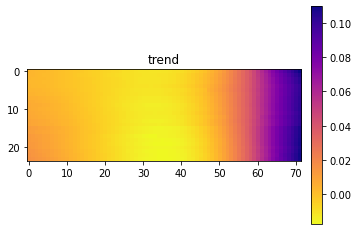

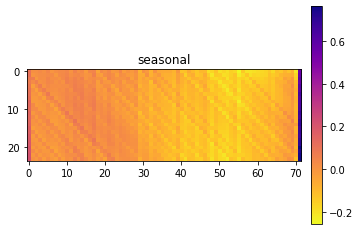

In [31]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

for name, w in weights_list.items():  
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()